In [2]:
import ndjson
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Read NDJSON file with keypoints recorded by Labelbox
ndjson_file = "../../ground_truth/Outdoor/court_keypoints/Outdoor.ndjson"  # NDJSON file path
with open(ndjson_file, "r") as f:
    data = ndjson.load(f)

# Key point names and corresponding court coordinate system coordinates
keypoint_mapping = {
    "rku_0": [0, 0],         
    "rku_1": [0, 1105],
    "rku_10": [1505, 0],       
    "rku_11": [1505, 1105]    
}

# Extract key point coordinates on the image from NDJSON
points_image = []
points_court = []

annotations = data[0]["projects"]["cm7u51amc06wh07woexn2g3g4"]["labels"][0]["annotations"]["objects"]
for annotation in annotations:
    key_name = annotation["value"]
    if key_name in keypoint_mapping:
        x, y = annotation["point"]["x"], annotation["point"]["y"]
        points_image.append([x, y])
        points_court.append(keypoint_mapping[key_name]) 

# Convert to numpy array
points_image = np.array(points_image, dtype=np.float32)
points_court = np.array(points_court, dtype=np.float32)

# Calculate homography matrix
H, status = cv2.findHomography(points_image, points_court)

print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 8.67168311e-01 -1.64447031e+00 -4.12433240e+02]
 [-1.33168361e-01 -3.70660422e+00  4.70488602e+03]
 [-1.02627370e-05 -1.70701600e-03  1.00000000e+00]]


In [3]:
def homographic_transformation(x, y, H):
    """Transform the coordinates on the image into the Court coordinate system by homographic transformation"""
    point = np.array([x, y, 1.0]).reshape(3, 1)  # Extended for homographic conversion
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]  # Normalization
    return transformed_point[0][0], transformed_point[1][0]  # (x', y')

# Court range (using keypoint_mapping)
min_x, min_y = keypoint_mapping["rku_0"]
max_x, max_y = keypoint_mapping["rku_11"]


In [ ]:
# Input folder (BoT-SORT output)
input_dir = "../../BoT-SORT_outputs/Outdoor"

# Output folder (court coordinate data)
output_dir_court = "../../BoT-SORT_outputs/Outdoor/transformed"
os.makedirs(output_dir_court, exist_ok=True)

# Output folder (filtered bbox data)
output_dir_bbox = "../../BoT-SORT_outputs/Outdoor/filtered"
os.makedirs(output_dir_bbox, exist_ok=True)

# Get MOT files
mot_files = glob.glob(os.path.join(input_dir, "*.txt"))


for mot_file in mot_files:
    
    # Read MOT files
    df = pd.read_csv(
        mot_file,
        header=None,
        names=["frame_id", "id", "x", "y", "width", "height", "conf", "class", "visibility", "empty"],
        sep=",",
    )

    # Calculate the midpoint of the bottom edge of bbox
    df["bottom_center_x"] = df["x"] + df["width"] / 2
    df["bottom_center_y"] = df["y"] + df["height"]

    # Homography transformation of the midpoint of the lower edge of each bbox
    transformed_coords = df.apply(
        lambda row: homographic_transformation(row["bottom_center_x"], row["bottom_center_y"], H),
        axis=1
    )

    # Save the transformed coordinates in new columns
    df["court_x"] = transformed_coords.map(lambda coord: coord[0])
    df["court_y"] = transformed_coords.map(lambda coord: coord[1])
    
    print("court_x: min=", df["court_x"].min(), "max=", df["court_x"].max())
    print("court_y: min=", df["court_y"].min(), "max=", df["court_y"].max())

    # 各トラックについて、コート内にいる判定に court_x, court_y を利用し、
    # コート内に連続して10フレーム以上いたことがないトラックを除外する
    # ----------------------------------
    def valid_track(group):
        # まず、コート内にある検出のみを抽出
        inside = group[(group["court_x"] >= min_x) & (group["court_x"] <= max_x) &
                       (group["court_y"] >= min_y) & (group["court_y"] <= max_y)]
        # コート内にいる検出フレームのリストを取得
        frames = sorted(inside["frame_id"].unique())
        
        # 連続するフレームの最大連続長を計算
        max_run = 1
        current_run = 1
        for i in range(1, len(frames)):
            if frames[i] == frames[i - 1] + 1:
                current_run += 1
            else:
                max_run = max(max_run, current_run)
                current_run = 1
        max_run = max(max_run, current_run)
        
        print("Track id:", group["id"].iloc[0], "Frames in court:", frames, "Max run:", max_run)
        
        # 連続してコート内にいる検出が10フレーム未満なら除外
        if max_run < 10:
            return False
        return True

    # 各トラック（idごと）でフィルタリング
    df = df.groupby("id").filter(valid_track)
    # ----------------------------------

    df = df.dropna() 
    
    df["frame_id"] = df["frame_id"].astype(int)  # 整数に変換
    df["id"] = df["id"].astype(int)  # 整数に変換
    
    # bbox data in original MOT format
    df_bbox = df[["frame_id", "id", "x", "y", "width", "height", "conf", "class", "visibility", "empty"]]

    # Data of court coordinates (bbox座標は削除してcourt座標のみを残す)
    df = df[["frame_id", "id", "court_x", "court_y"]]

    # 入力ファイルからの相対パスを保持
    relative_path = os.path.relpath(mot_file, input_dir)
    
    # Save converted MOT data (court coordinates)
    output_file_court = os.path.join(output_dir_court, relative_path)
    os.makedirs(os.path.dirname(output_file_court), exist_ok=True)
    df.to_csv(output_file_court, index=False, header=None, sep=",")  # MOT形式で保存

    # Save converted MOT data (original bbox format)
    output_file_bbox = os.path.join(output_dir_bbox, relative_path)
    os.makedirs(os.path.dirname(output_file_bbox), exist_ok=True)
    df_bbox.to_csv(output_file_bbox, index=False, header=None, sep=",")  # MOT形式で保存

    print(f"Processed: {mot_file} -> {output_file_court}, {output_file_bbox}")

print(f"Convert all MOT files, saved in {output_dir_court} (court coordinates) and {output_dir_bbox} (bboxes data).")

court_x: min= -633.8320066825038 max= 1445.6184558668854
court_y: min= -385.02675960828736 max= 1199.4704924137113
Track id: 1 Frames in court: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 

Visualizing: ../BoT-SORT_outputs/Outdoor/IMG_0104_1.txt


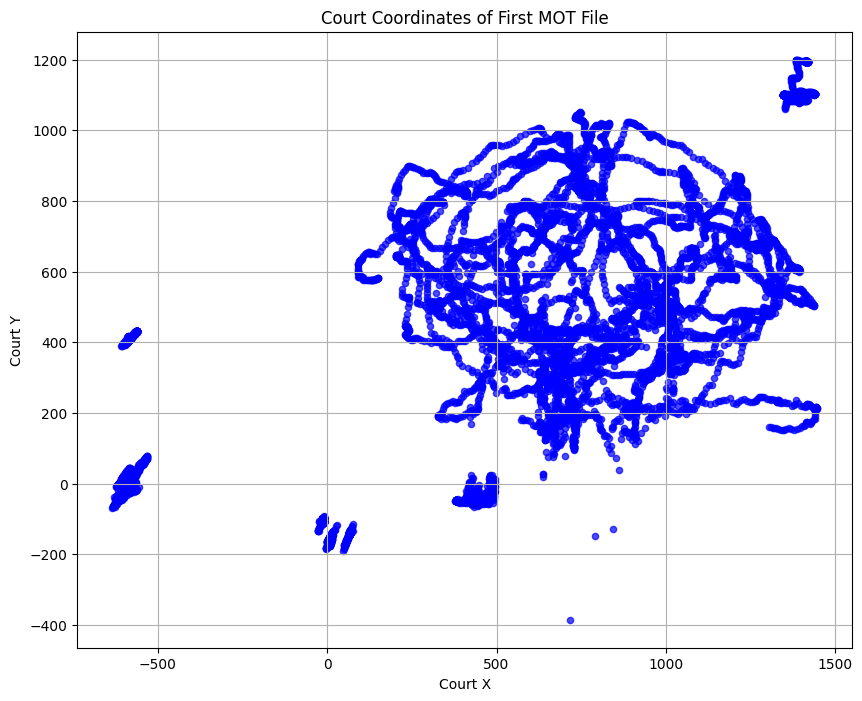

In [ ]:
# MOTファイルのリストを取得（すでに定義済みの場合はこの部分は不要です）
input_dir = "../../BoT-SORT_outputs/Outdoor"
mot_files = glob.glob(os.path.join(input_dir, "*.txt"))

# 一番最初のファイルを選択
first_file = mot_files[0]
print("Visualizing:", first_file)

# ファイルを読み込む
df = pd.read_csv(
    first_file,
    header=None,
    names=["frame_id", "id", "x", "y", "width", "height", "conf", "class", "visibility", "empty"],
    sep=",",
)

# bboxの下辺中央の座標を計算
df["bottom_center_x"] = df["x"] + df["width"] / 2
df["bottom_center_y"] = df["y"] + df["height"]

# ホモグラフィ変換を適用
# H_corrected と homographic_transformation は既に定義されている前提
transformed_coords = df.apply(
    lambda row: homographic_transformation(row["bottom_center_x"], row["bottom_center_y"], H),
    axis=1
)

# court_x, court_yカラムに変換結果を保存
df["court_x"] = transformed_coords.map(lambda coord: coord[0])
df["court_y"] = transformed_coords.map(lambda coord: coord[1])

# 可視化（散布図）
plt.figure(figsize=(10, 8))
plt.scatter(df["court_x"], df["court_y"], s=20, c='blue', alpha=0.7)
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.title("Court Coordinates of First MOT File")
plt.grid(True)
plt.show()

動画ファイルは存在します
Frame dimensions: width = 3840 , height = 2160
Using MOT file: ../BoT-SORT_outputs/Outdoor/IMG_0104_1.txt


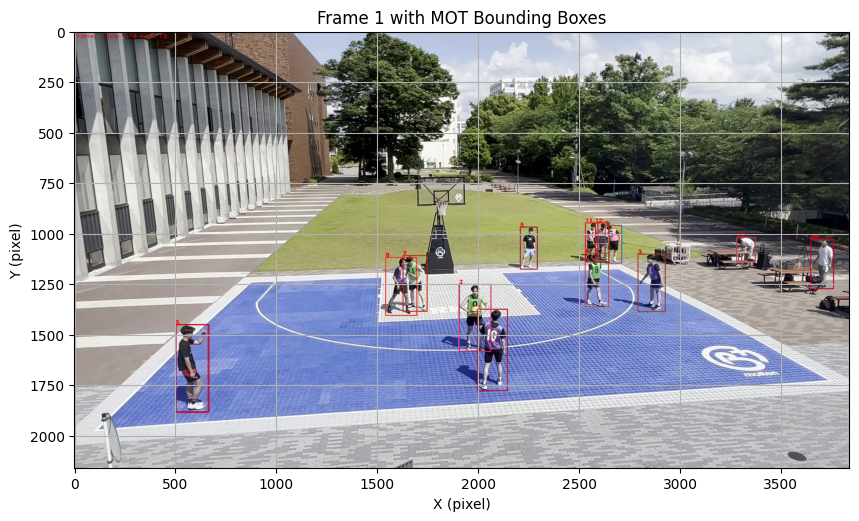

In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

# --- 動画から1フレームを取得する ---
video_file = "../../BoT-SORT_outputs/Outdoor/2025_02_18_11_19_05/IMG_0104_1.MOV"
if not os.path.exists(video_file):
    print("動画ファイルが存在しません:", video_file)
else:
    print("動画ファイルは存在します")
cap = cv2.VideoCapture(video_file)
ret, frame = cap.read()
if not ret:
    raise ValueError("動画からフレームが取得できませんでした")
cap.release()

# フレームのサイズを確認
frame_height, frame_width = frame.shape[:2]
print("Frame dimensions: width =", frame_width, ", height =", frame_height)

# OpenCVはBGRなのでRGBに変換（可視化用）
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- MOTファイルを読み込む ---
# ここでは一番最初のMOTファイルを対象としています
input_dir = "../BoT-SORT_outputs/Outdoor"
mot_files = glob.glob(os.path.join(input_dir, "*.txt"))
if not mot_files:
    raise FileNotFoundError("MOTファイルが見つかりません")
mot_file = mot_files[0]
print("Using MOT file:", mot_file)

df = pd.read_csv(
    mot_file,
    header=None,
    names=["frame_id", "id", "x", "y", "width", "height", "conf", "class", "visibility", "empty"],
    sep=",",
)

# --- 特定のフレームを選択してオーバーレイする ---
# ここでは例として、最初のフレーム (frame_id == 1) の検出を抽出します
frame_to_visualize = 1
df_frame = df[df["frame_id"] == frame_to_visualize]

# --- 元フレームにバウンディングボックスを描画する ---
# ボックスの色や線の太さは適宜調整してください
for _, row in df_frame.iterrows():
    x, y, w, h = int(row["x"]), int(row["y"]), int(row["width"]), int(row["height"])
    cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)
    # 識別用にIDも描画
    cv2.putText(frame_rgb, str(int(row["id"])), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# --- 結果を表示 ---
plt.figure(figsize=(10, 8))
plt.imshow(frame_rgb)
plt.title(f"Frame {frame_to_visualize} with MOT Bounding Boxes")
plt.xlabel("X (pixel)")
plt.ylabel("Y (pixel)")
plt.grid(True)
plt.show()


Animating trajectories from: ../BoT-SORT_outputs/Outdoor/transformed/IMG_0104_1.txt
Total frames: 1118


/tmp/ipykernel_1826176/4227639095.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", num_ids)


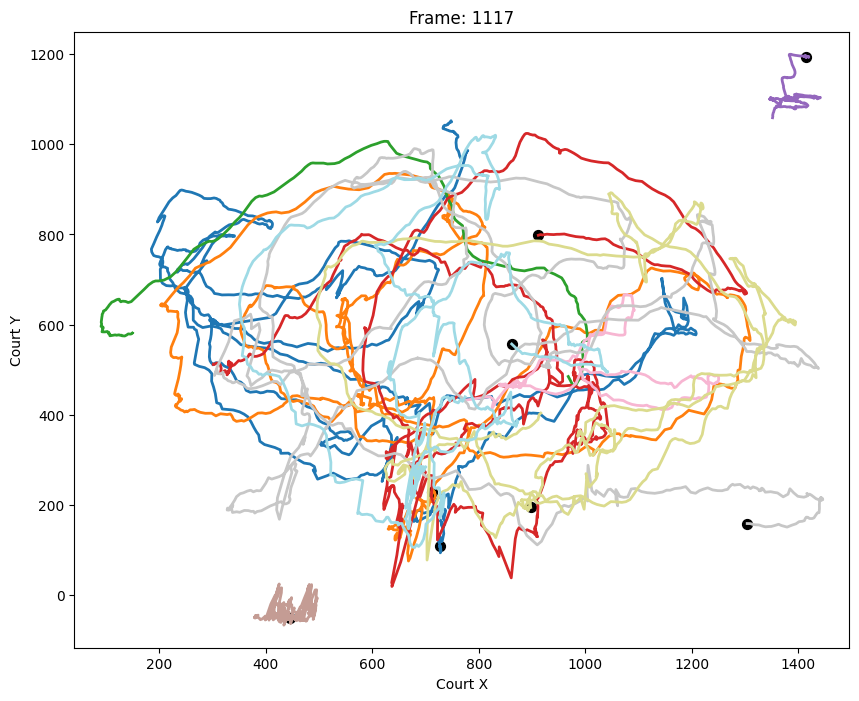

In [ ]:
import matplotlib.animation as animation
import matplotlib.cm as cm
import numpy as np

# --- 出力されたcourt座標のMOTファイルを読み込む ---
output_dir_court = "../../BoT-SORT_outputs/Outdoor/transformed/"
court_files = glob.glob(os.path.join(output_dir_court, "*.txt"))
if not court_files:
    raise FileNotFoundError("output_dir_court 内にファイルが見つかりません。")
# ここでは一番最初のファイルを対象とします
tracking_file = court_files[0]
print("Animating trajectories from:", tracking_file)

# 保存時はヘッダーなしなので、列名を指定
df = pd.read_csv(tracking_file, header=None, names=["frame_id", "id", "court_x", "court_y"], sep=",")
df = df.sort_values(by="frame_id")

# --- フレームごとにデータを抽出 ---
frames = sorted(df["frame_id"].unique())
print("Total frames:", len(frames))

# --- 描画のための設定 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 軸の範囲は全データの範囲から決定（適宜余白を設定）
margin = 50
x_min, x_max = df["court_x"].min() - margin, df["court_x"].max() + margin
y_min, y_max = df["court_y"].min() - margin, df["court_y"].max() + margin
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Court X")
ax.set_ylabel("Court Y")
title_text = ax.set_title("Frame: 0")

# --- 各トラックごとに色を割り当て ---
unique_ids = sorted(df["id"].unique())
num_ids = len(unique_ids)
cmap = cm.get_cmap("tab20", num_ids)
track_colors = {track_id: cmap(i) for i, track_id in enumerate(unique_ids)}

# 各トラックの軌跡（過去の座標）を更新する Line オブジェクトを作成
lines = {}
for track_id in unique_ids:
    line, = ax.plot([], [], lw=2, color=track_colors[track_id], label=f"ID {track_id}")
    lines[track_id] = line

# 現在のフレームの検出位置を示す scatter オブジェクト
scat = ax.scatter([], [], s=50, c="black")

# --- 初期化関数 ---
def init():
    for line in lines.values():
        line.set_data([], [])
    scat.set_offsets(np.empty((0, 2)))
    title_text.set_text("Frame: 0")
    return list(lines.values()) + [scat, title_text]

# --- 更新関数 ---
def animate(frame_index):
    current_frame = frames[frame_index]
    # 現在フレームの検出データ
    current_data = df[df["frame_id"] == current_frame]
    
    # 各トラックの軌跡を更新（現在フレームまでの全データ）
    for track_id in unique_ids:
        track_data = df[(df["id"] == track_id) & (df["frame_id"] <= current_frame)]
        if not track_data.empty:
            x_vals = track_data["court_x"].values
            y_vals = track_data["court_y"].values
            lines[track_id].set_data(x_vals, y_vals)
        else:
            lines[track_id].set_data([], [])
            
    # 現在の検出位置を scatter で更新
    if not current_data.empty:
        offsets = current_data[["court_x", "court_y"]].values
        scat.set_offsets(offsets)
    else:
        scat.set_offsets(np.empty((0, 2)))
    
    title_text.set_text(f"Frame: {current_frame}")
    return list(lines.values()) + [scat, title_text]

# --- アニメーション作成 ---
ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                              init_func=init, blit=True, interval=100)

# --- 動画ファイルとして保存 ---
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Your Name'), bitrate=1800)
ani.save("trajectories.mp4", writer=writer)

plt.show()

In [4]:
import os
import numpy as np
import re
import csv

# 入力フォルダの設定（MOT形式のtxtと対応するCSV）
mot_folder = '../../ground_truth/Outdoor/MOT_files'
csv_folder = '../../ground_truth/Outdoor/delimitation_frames'

# 出力先のベースフォルダを作成し、さらに free_throw と check_ball のサブフォルダを作成
base_output_folder = os.path.join(mot_folder, 'split_transformed')
free_throw_folder = os.path.join(base_output_folder, 'free_throw')
check_ball_folder = os.path.join(base_output_folder, 'check_ball')
os.makedirs(free_throw_folder, exist_ok=True)
os.makedirs(check_ball_folder, exist_ok=True)

# MOTファイルごとに処理
for mot_file in os.listdir(mot_folder):
    if not mot_file.lower().endswith('.txt'):
        continue
    base_name = os.path.splitext(mot_file)[0]  # 例: IMG_0104
    mot_path = os.path.join(mot_folder, mot_file)
    csv_path = os.path.join(csv_folder, base_name + '.csv')
    if not os.path.exists(csv_path):
        print(f"[警告] {mot_file} に対応するCSVファイルが見つかりません。")
        continue

    # ① MOTファイルを読み込み、各bboxの下辺中点をホモグラフィ変換
    # 出力レコードは (frame, id, court_x, court_y)
    transformed_records = []  
    with open(mot_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # カンマ区切りまたはスペース区切りに対応
            if ',' in line:
                parts = [p.strip() for p in line.split(',')]
                try:
                    # 0始まりの場合、+1
                    frame_num = int(float(parts[0])) + 1
                except ValueError:
                    continue
            else:
                parts = line.split()
                try:
                    frame_num = int(float(parts[0]))
                except ValueError:
                    continue
            try:
                track_id = int(float(parts[1]))
                x, y, w, h = map(float, parts[2:6])
            except ValueError:
                continue
            
            # bboxの下辺中点を計算： (x + w/2, y + h)
            bottom_mid_x = x + w / 2.0
            bottom_mid_y = y + h
            
            # ホモグラフィ変換
            court_x, court_y = homographic_transformation(bottom_mid_x, bottom_mid_y, H)
            
            transformed_records.append((frame_num, track_id, court_x, court_y))
    
    # ② CSVファイルの読み込み（全行読み込む）
    csv_rows = []
    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if row:
                csv_rows.append(row)
    
    if len(csv_rows) % 2 != 0:
        print(f"[警告] {csv_path} の行数が奇数です。最後の行は無視されます。")
    
    # ③ 背番号マッピングはCSVの最初に記載されているため、最初に全体の背番号マッピングを取得
    global_jersey_map = {}
    for row in csv_rows:
        if len(row) >= 2 and row[1].strip() != "":
            jersey_str = row[1].strip()  # 例："1:10, 3: 6, 4: 4, 5: 12, 6: 9, 8: 11"
            for part in jersey_str.split(','):
                subparts = part.split(':')
                if len(subparts) == 2:
                    try:
                        global_jersey_map[int(subparts[0].strip())] = subparts[1].strip()
                    except ValueError:
                        continue
            break  # 1行目のみ使用する

    # ④ セグメントごとに処理（CSVは2行ごとに1セグメント）
    segments = []
    for i in range(0, len(csv_rows) - 1, 2):
        row_odd = csv_rows[i]   # マッピング情報が含まれる行（チーム情報も含む場合がある）
        row_even = csv_rows[i + 1]
        
        # CSV第1列からフレーム番号を抽出
        m1 = re.match(r'(\d+)', row_odd[0].strip())
        m2 = re.match(r'(\d+)', row_even[0].strip())
        if not (m1 and m2):
            continue
        start_frame = int(m1.group(1))
        end_frame = int(m2.group(1))
        
        # 背番号マッピングはグローバルなものを使用
        jersey_map = global_jersey_map
        
        # チームマッピングは row_odd の第3列から抽出（例："Offense: 1, 4, 5; Defense: 3, 6, 8"）
        team_map = {}
        if len(row_odd) > 2:
            team_str = row_odd[2].strip()
            if team_str:
                for part in team_str.split(';'):
                    part = part.strip()
                    if part.startswith("Offense"):
                        ids_str = part[len("Offense:"):].strip()
                        for id_item in ids_str.split(','):
                            try:
                                team_map[int(id_item.strip())] = "O"
                            except ValueError:
                                continue
                    elif part.startswith("Defense"):
                        ids_str = part[len("Defense:"):].strip()
                        for id_item in ids_str.split(','):
                            try:
                                team_map[int(id_item.strip())] = "D"
                            except ValueError:
                                continue
        
        # セグメントタイプの判定：row_oddの1列目に "Just before the referee releases the ball" が含まれていれば free_throw、
        # それ以外は check_ball
        seg_label = row_odd[0].strip()
        seg_type = "free_throw" if "Just before the referee releases the ball" in seg_label else "check_ball"
        
        segments.append({
            "start_frame": start_frame,
            "end_frame": end_frame,
            "jersey_map": jersey_map,
            "team_map": team_map,
            "type": seg_type
        })
    
    # ⑤ 各セグメントごとに、対象のレコードを抽出し、フレーム番号を1始まりにリベースし、追加列（例："O10" や "D6"）を付与
    for seg_idx, seg in enumerate(segments, start=1):
        seg_start = seg["start_frame"]
        seg_end = seg["end_frame"]
        jersey_map = seg["jersey_map"]
        team_map = seg["team_map"]
        seg_type = seg["type"]
        
        segment_output = []
        for rec in transformed_records:
            orig_frame, track_id, court_x, court_y = rec
            if seg_start <= orig_frame <= seg_end:
                # セグメント内でフレーム番号を1始まりにリベース
                new_frame = orig_frame - seg_start + 1
                extra = ""
                if track_id in team_map and track_id in jersey_map:
                    extra = team_map[track_id] + jersey_map[track_id]
                segment_output.append((new_frame, track_id, court_x, court_y, extra))
        
        # 出力先フォルダの選択（free_throw または top）
        folder = free_throw_folder if seg_type == "free_throw" else check_ball_folder
        
        # ⑥ 分割後のtxtファイルとして、カンマ区切りで保存（列名は不要）
        out_filename = f"{base_name}_{seg_idx}.txt"
        out_path = os.path.join(folder, out_filename)
        with open(out_path, 'w', newline='') as fout:
            writer = csv.writer(fout)
            for rec in segment_output:
                writer.writerow([rec[0], rec[1], f"{rec[2]:.3f}", f"{rec[3]:.3f}", rec[4]])
        print(f"セグメント {seg_idx} ({seg_type}) を {out_path} に保存しました。")


セグメント 1 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0110_1.txt に保存しました。
セグメント 2 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0110_2.txt に保存しました。
セグメント 3 (free_throw) を ../../ground_truth/Outdoor/MOT_files/split_transformed/free_throw/IMG_0110_3.txt に保存しました。
セグメント 4 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0110_4.txt に保存しました。
セグメント 5 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0110_5.txt に保存しました。
セグメント 6 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0110_6.txt に保存しました。
セグメント 1 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_0111_1.txt に保存しました。
セグメント 2 (free_throw) を ../../ground_truth/Outdoor/MOT_files/split_transformed/free_throw/IMG_0111_2.txt に保存しました。
セグメント 3 (check_ball) を ../../ground_truth/Outdoor/MOT_files/split_transformed/check_ball/IMG_011